<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
import time

In [2]:
try:
    data = pd.read_csv('C:/Users/Ксения/data_analyst/****/****i.csv')
except:
    data = pd.read_csv('/datasets/****i.csv')

In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
# Изменим тип данных
data['datetime'] = data['datetime'].astype('datetime64')
data = data.drop_duplicates().reset_index(drop = True)

# Проверим последовательность
data['datetime'].is_monotonic


True

In [6]:
# Столбец в индекс
data = data.set_index('datetime')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

In [9]:
# Для красивых графиков
figsize=(25,8)
plt.rcParams['font.size'] = '16'

In [10]:
# Посмотрим отрезок времени
print("Данные предоставлены за период:")
print(data.index.min(), " - " , data.index.max())

Данные предоставлены за период:
2018-03-01 00:00:00  -  2018-08-31 23:00:00


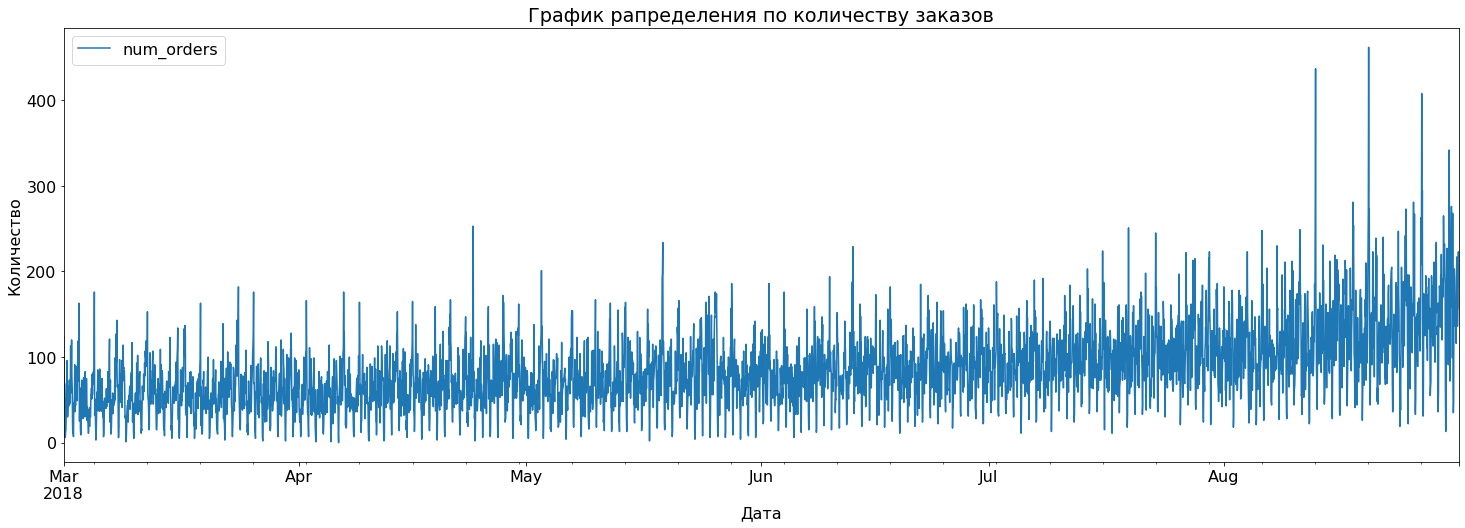

In [11]:
data.plot(figsize=figsize, title = 'График рапределения по количеству заказов')
plt.xlabel('Дата')
plt.ylabel('Количество');

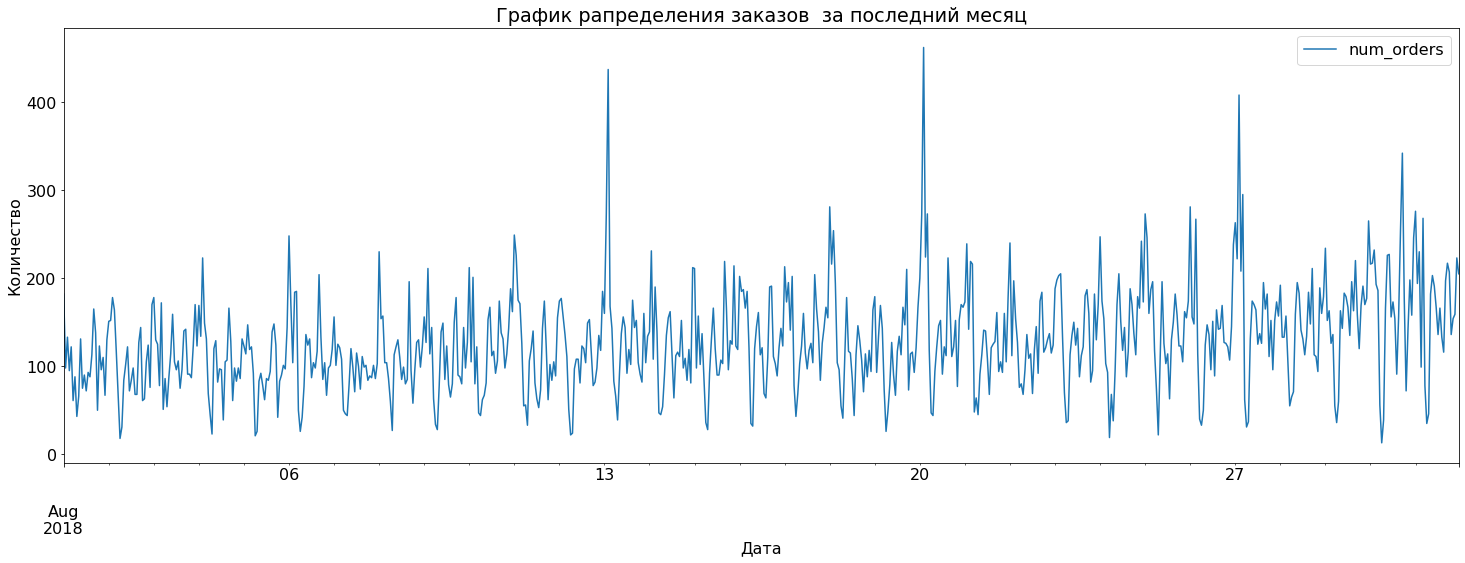

In [12]:
# посмотрим детально месяц
data_lt_mth = data['2018-08-01':'2018-08-31']
data_lt_mth.plot(figsize=figsize, title = 'График рапределения заказов  за последний месяц')
plt.xlabel('Дата')
plt.ylabel('Количество')
None

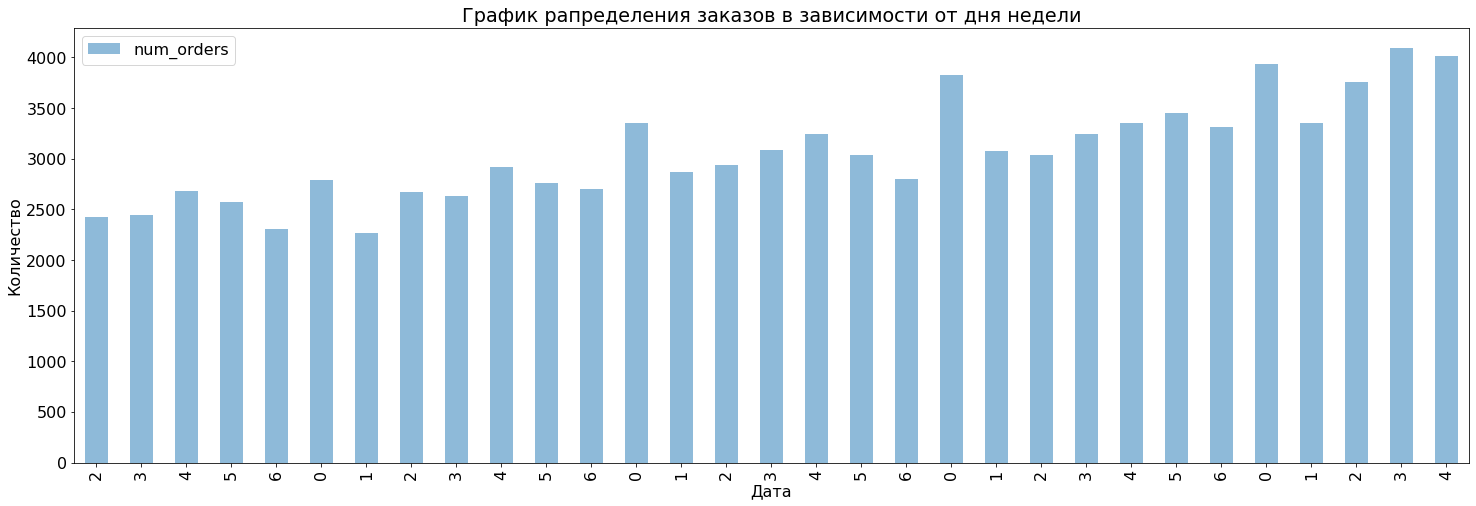

In [13]:
# посмотрим детально месяц по дням недели

data_lt_week = data_lt_mth.resample('1D').sum().reset_index()

data_lt_week['datetime'] = pd.to_datetime(data_lt_week['datetime'], format = '%Y/%m/%d %H:%M:%S')
data_lt_week['datetime'] = data_lt_week['datetime'].dt.weekday
data_lt_week = data_lt_week.set_index('datetime')

# посмотрим зависимость от дня недели
data_lt_week.plot(figsize=figsize, kind = 'bar', title = 'График рапределения заказов в зависимости от дня недели', alpha = 0.5)
plt.xlabel('Дата')
plt.ylabel('Количество')
None

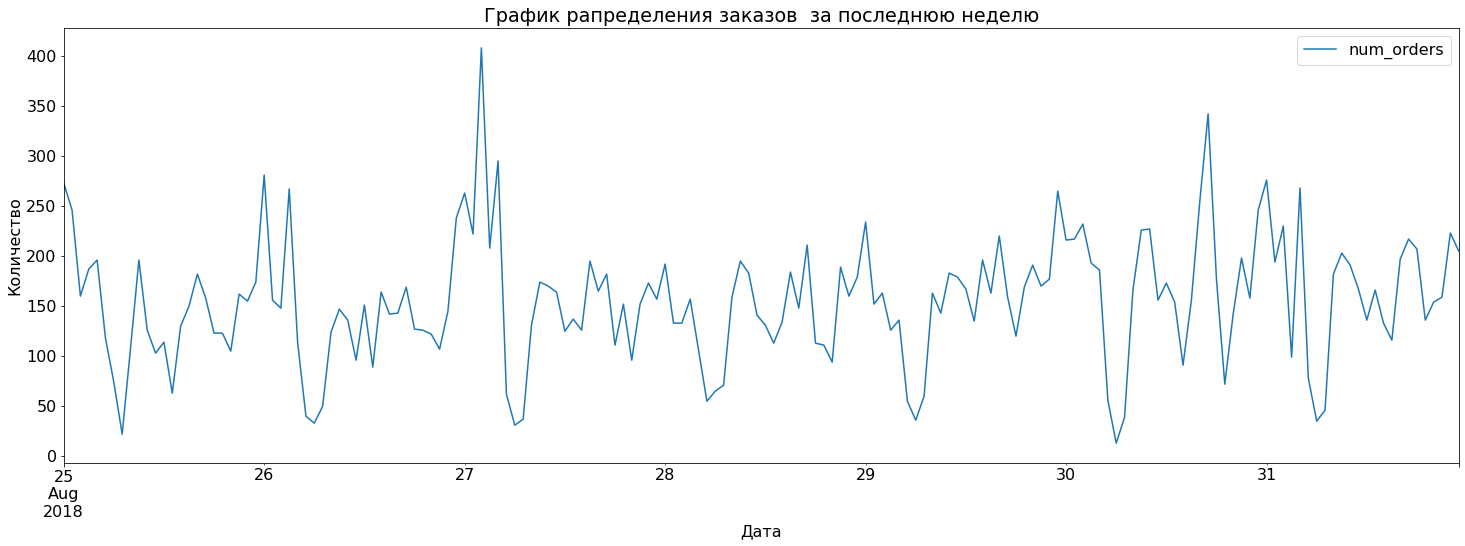

In [14]:
# посмотрим детально неделю
data_lt_wk = data['2018-08-25':'2018-08-31']
data_lt_wk.plot(figsize=figsize, title = 'График рапределения заказов  за последнюю неделю')
plt.xlabel('Дата')
plt.ylabel('Количество')
None

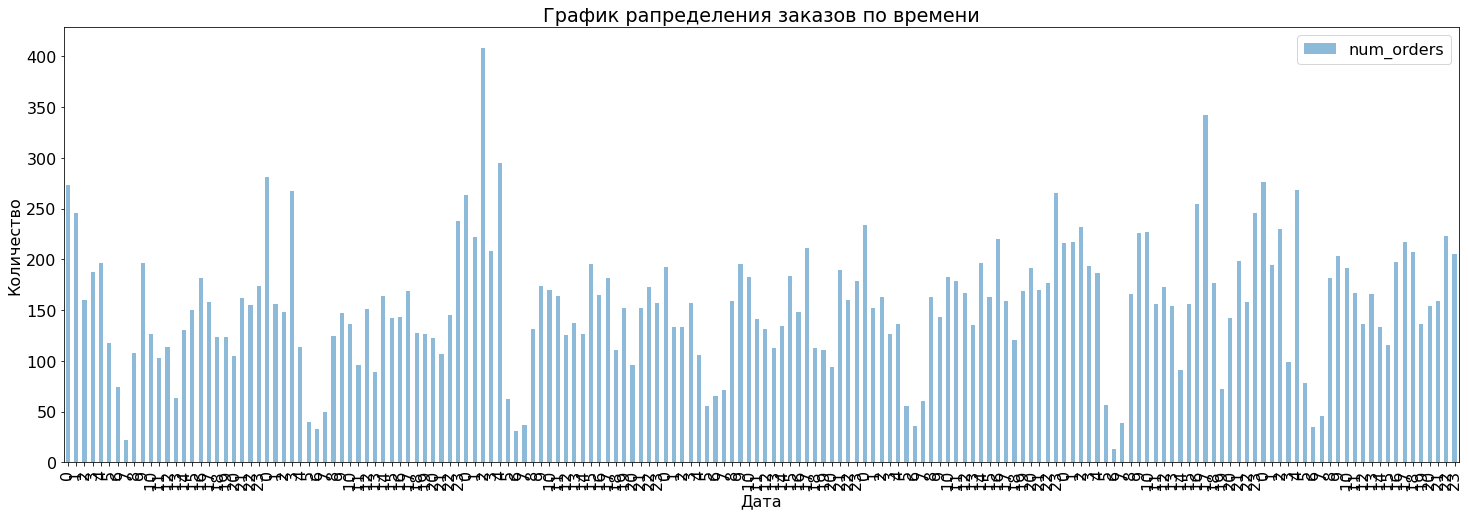

In [15]:
# посмотрим детально месяц времени заказа

data_lt_hour = data_lt_wk.reset_index()
#data_lt_hour['datetime'] = pd.to_datetime(data_lt_week['datetime'], format = '%Y/%m/%d %H:%M:%S')
data_lt_hour['datetime'] = data_lt_hour['datetime'].dt.hour
data_lt_hour = data_lt_hour.set_index('datetime')


data_lt_hour.plot(figsize=figsize, kind = 'bar', title = 'График рапределения заказов по времени', alpha = 0.5)
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.xticks(rotation=90)
None

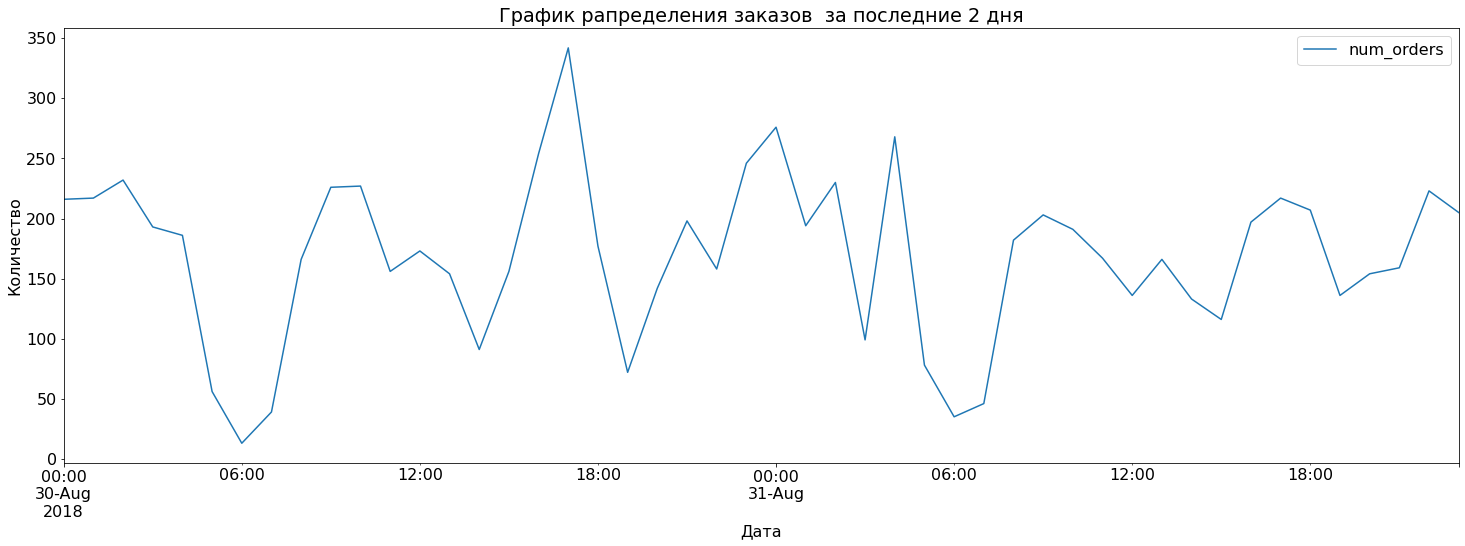

In [16]:
# посмотрим детально последние 2 дня
data_lt_2d = data['2018-08-30':'2018-08-31']
data_lt_2d.plot(figsize=figsize, title = 'График рапределения заказов  за последние 2 дня')
plt.xlabel('Дата')
plt.ylabel('Количество')
None

In [17]:
def rolling_mean(data, title):
    title = 'Скользящее среднее ' + title
    data.plot(figsize=figsize, title = title)
    plt.xlabel('Дата')
    plt.ylabel('Количество')
    plt.show()
    None

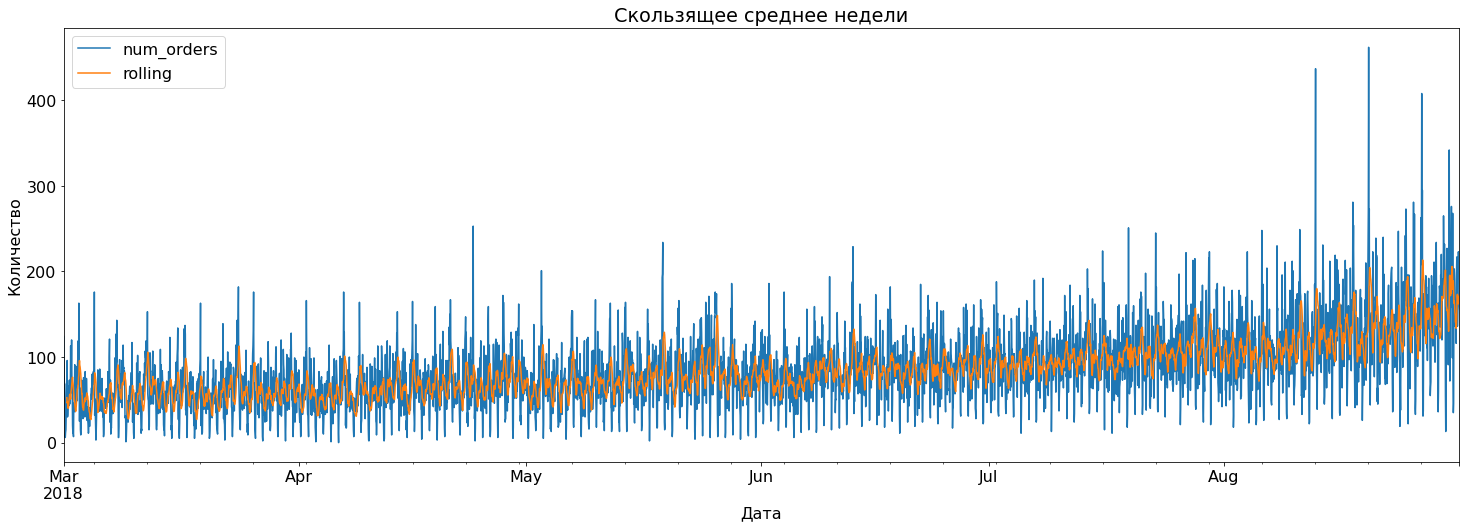

In [18]:
# Скользящее среднее за весь период
data['rolling'] = data.shift().rolling(10).mean()
rolling_mean(data, 'недели')

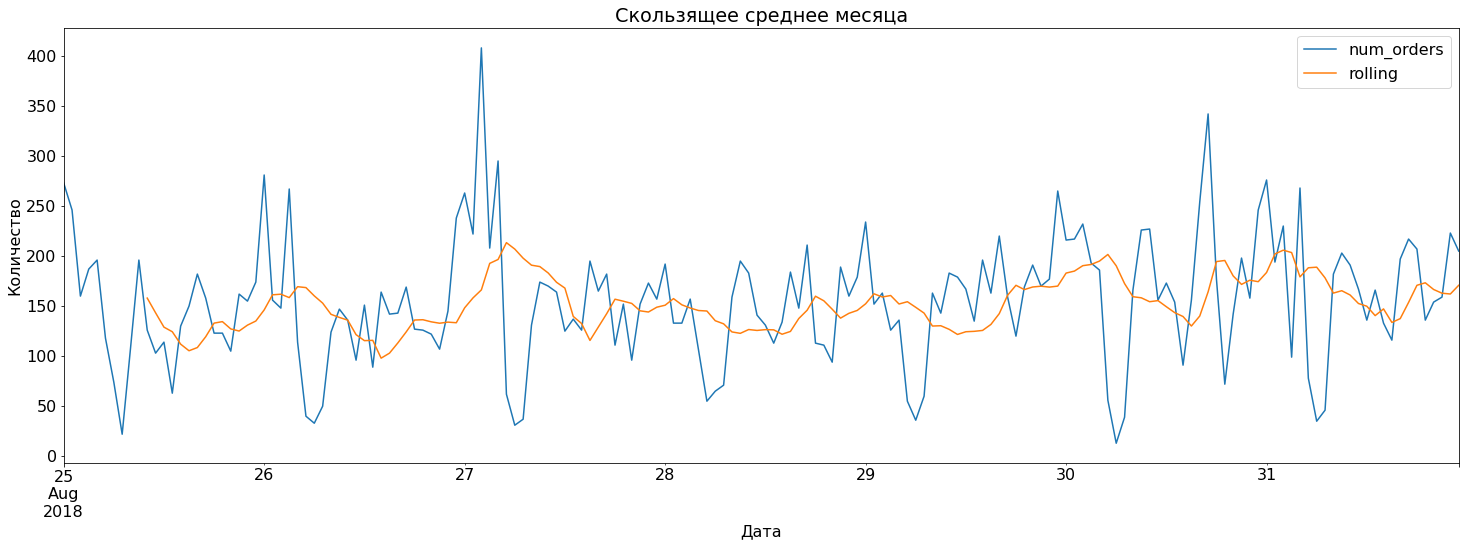

In [19]:
# Скользящее среднее месяца
data_lt_wk['rolling'] = data_lt_wk.shift().rolling(10).mean()
rolling_mean(data_lt_wk, 'месяца')

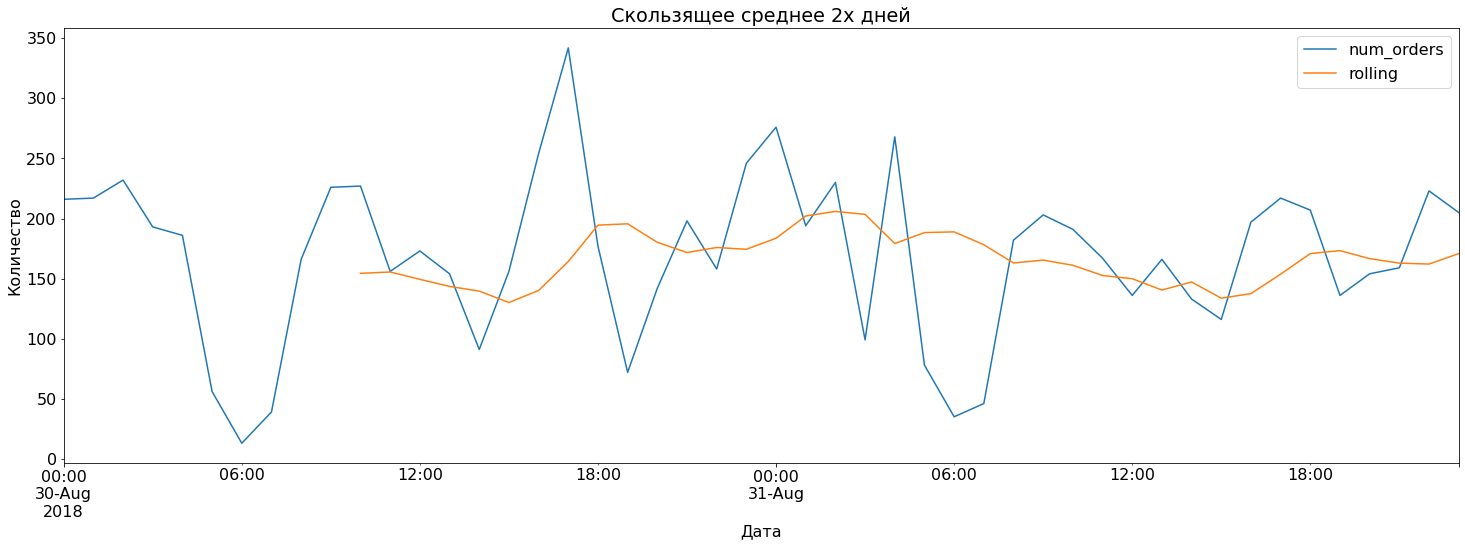

In [20]:
# Скользящее среднее 2х дней
data_lt_2d['rolling'] = data_lt_2d.shift().rolling(10).mean()
rolling_mean(data_lt_2d, '2х дней')

In [21]:
# декомпозиция
decomposed = seasonal_decompose(data.num_orders)
decomposed_lt_mth = seasonal_decompose(data_lt_mth.num_orders)
decomposed_lt_2d = seasonal_decompose(data_lt_2d.num_orders)

In [22]:
def trend_graph(data, title):
    title = 'Тренд ' + title
    data.trend.plot(figsize=figsize, title = title)
    plt.xlabel('Дата')
    plt.ylabel('Количество')
    None

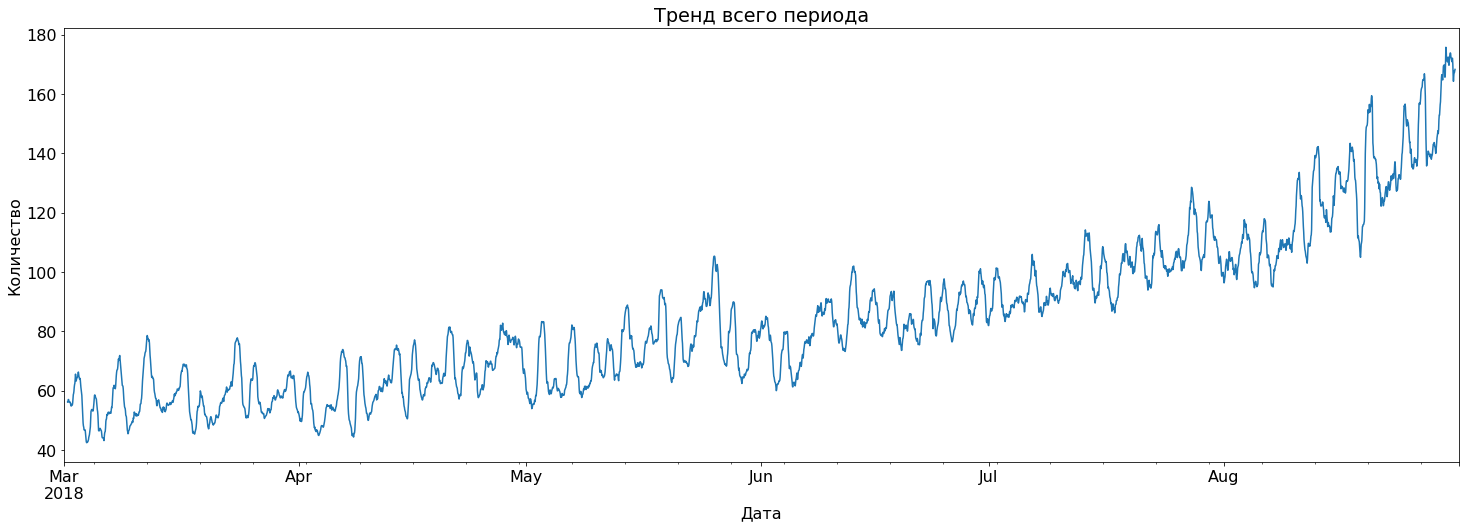

In [23]:
# посмотрим тренд всех данных
trend_graph(decomposed, 'всего периода')

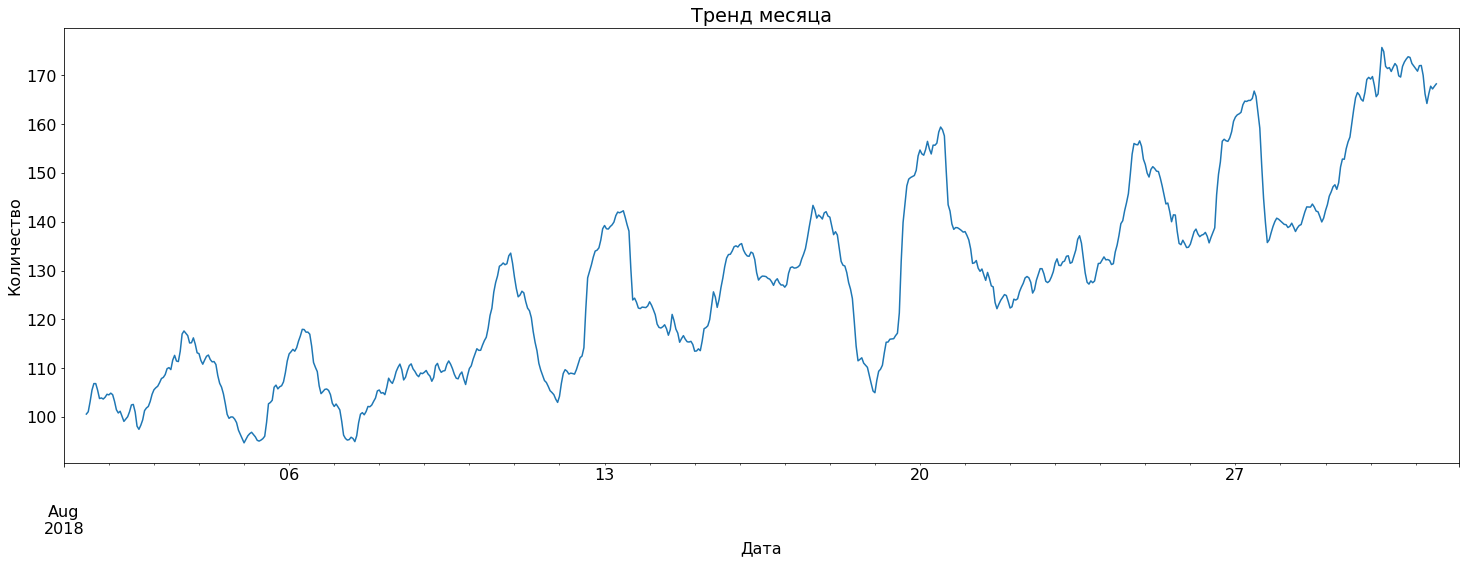

In [24]:
# посмотрим тренд всех месяца
trend_graph(decomposed_lt_mth, 'месяца')

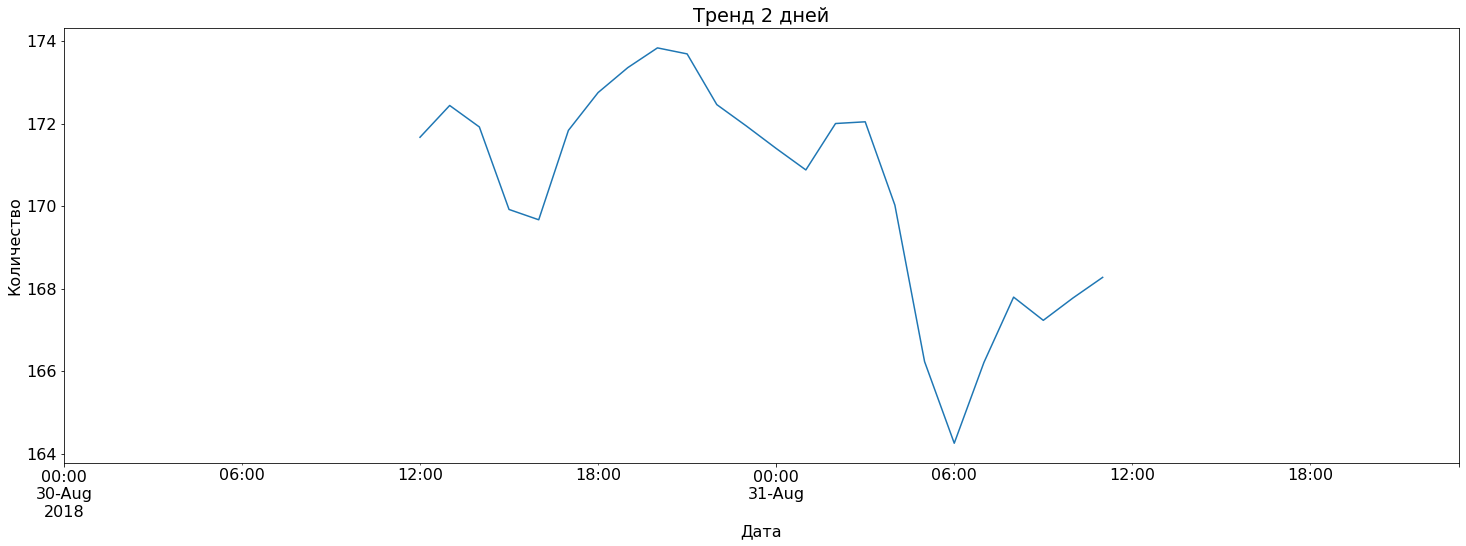

In [25]:
# посмотрим тренд всех 2 дней
trend_graph(decomposed_lt_2d, '2 дней')

In [26]:
def seasonal_graph(data, title):
    title = 'Сезонность ' + title
    data.seasonal.plot(figsize=figsize, title = title)
    plt.xlabel('Дата')
    plt.ylabel('Количество')
    None

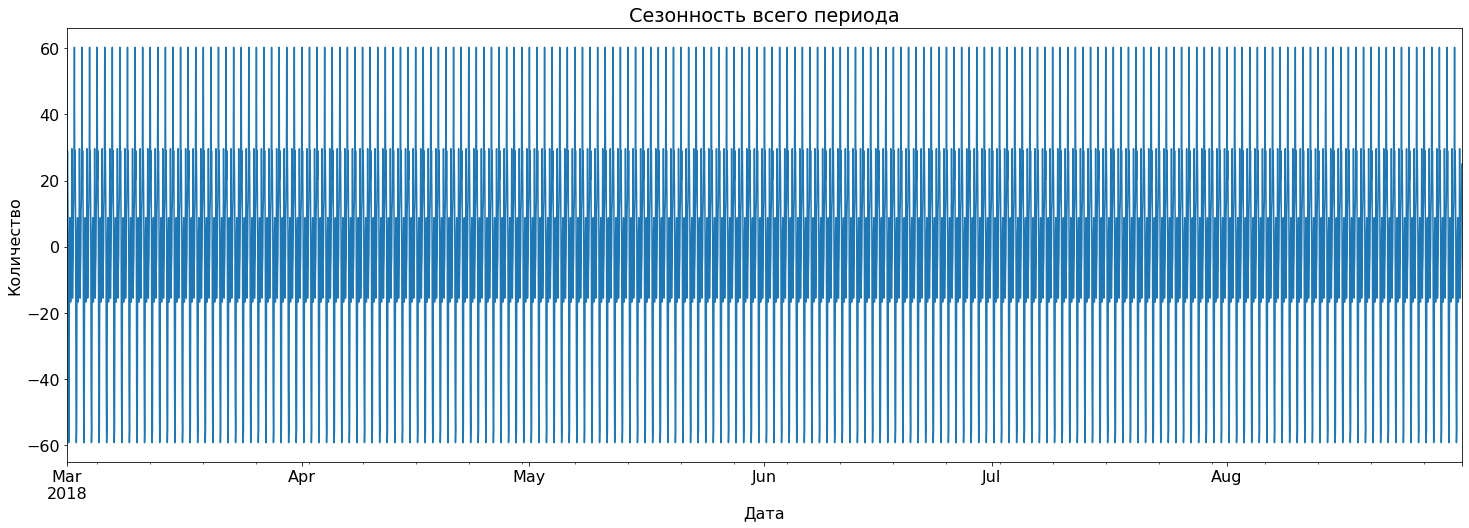

In [27]:
# посмотрим сезонность всех данных
seasonal_graph(decomposed, 'всего периода')

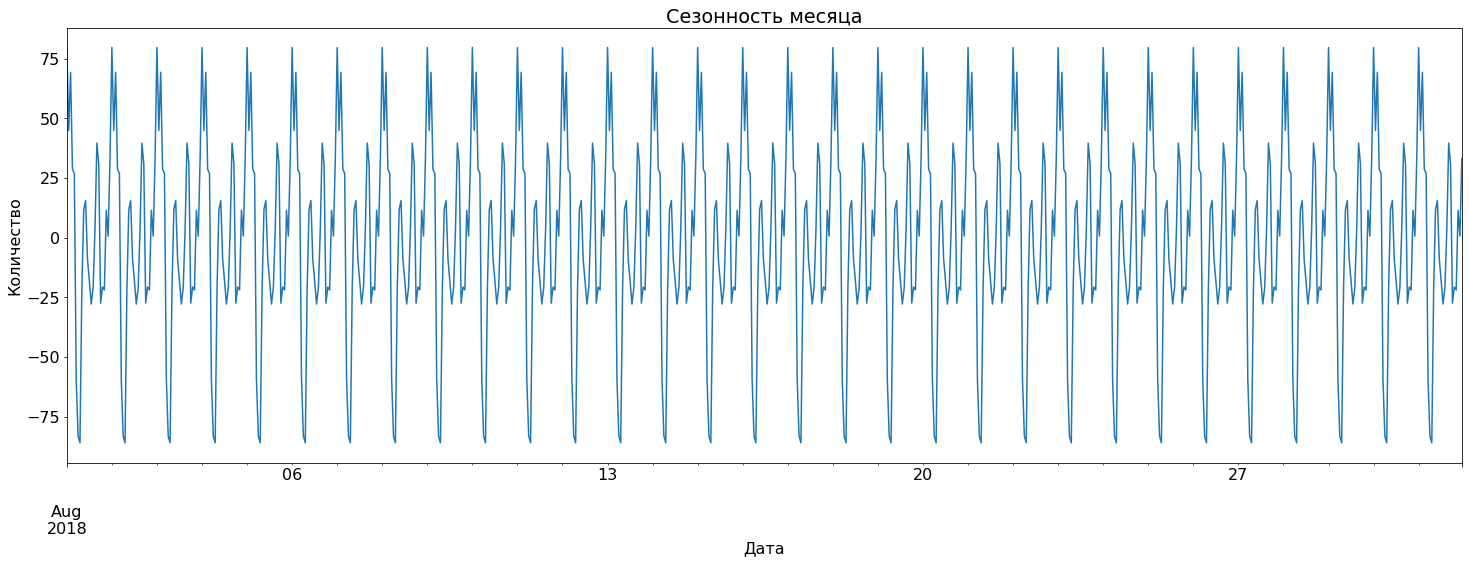

In [28]:
# посмотрим сезонность месяца
seasonal_graph(decomposed_lt_mth, 'месяца')

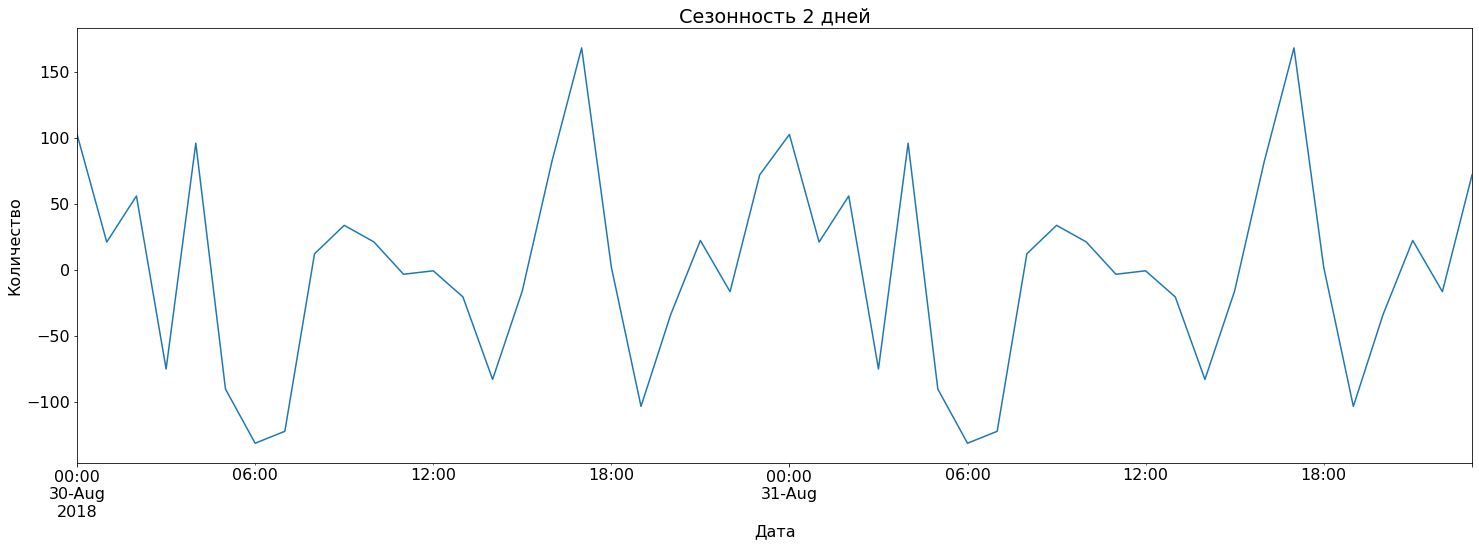

In [29]:
# посмотрим сезонность 2 дней
seasonal_graph(decomposed_lt_2d, '2 дней')

In [30]:
def resid_graph(data, title):
    title = 'Остаток декомпозиции ' + title
    data.resid.plot(figsize=figsize, title = title)
    plt.xlabel('Дата')
    plt.ylabel('Количество')
    None

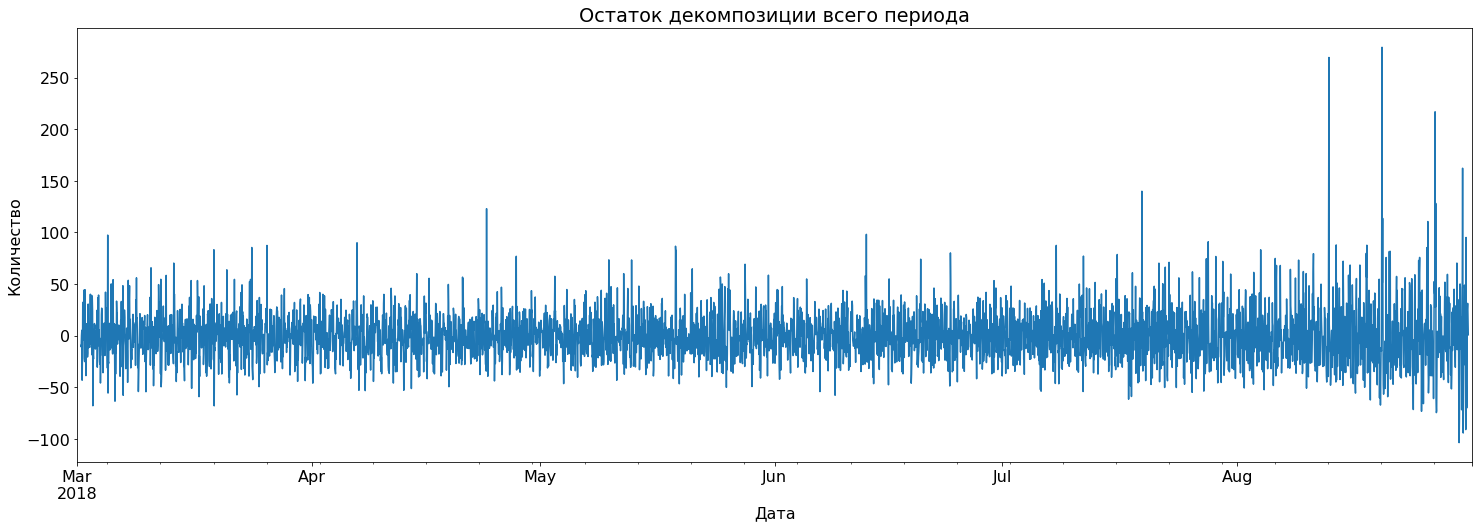

In [31]:
# остаток декомпозиции всех данных
resid_graph(decomposed, 'всего периода')

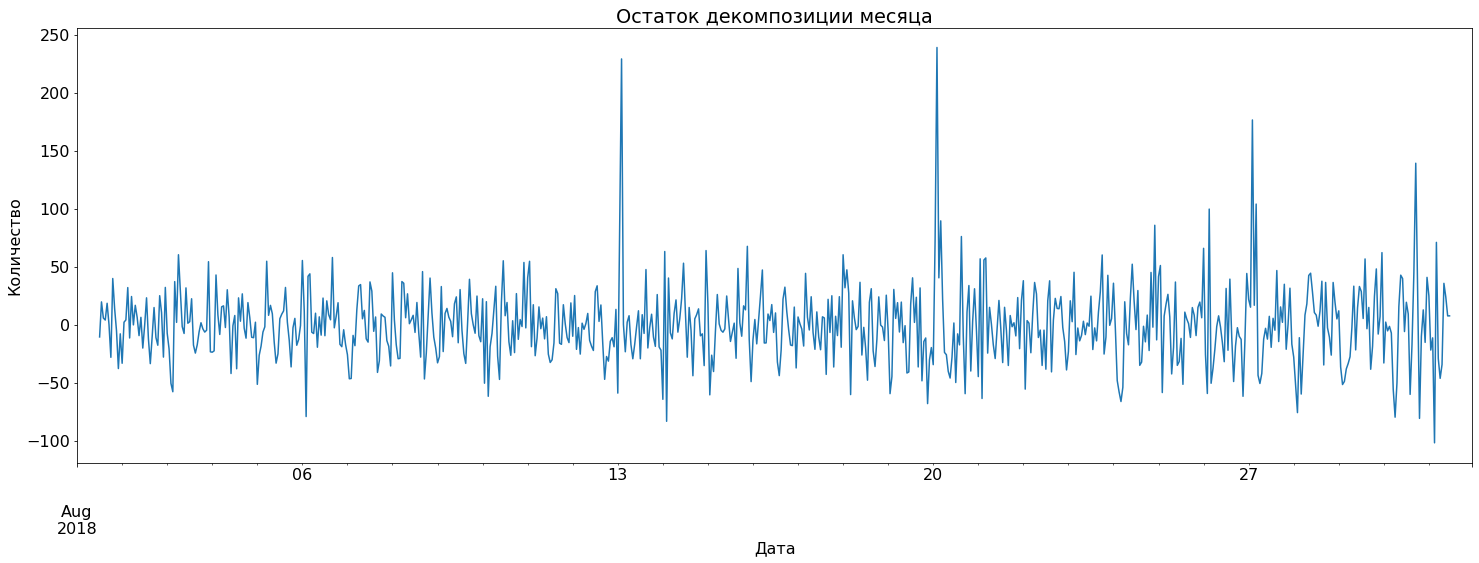

In [32]:
# остаток декомпозиции месяца
resid_graph(decomposed_lt_mth, 'месяца')

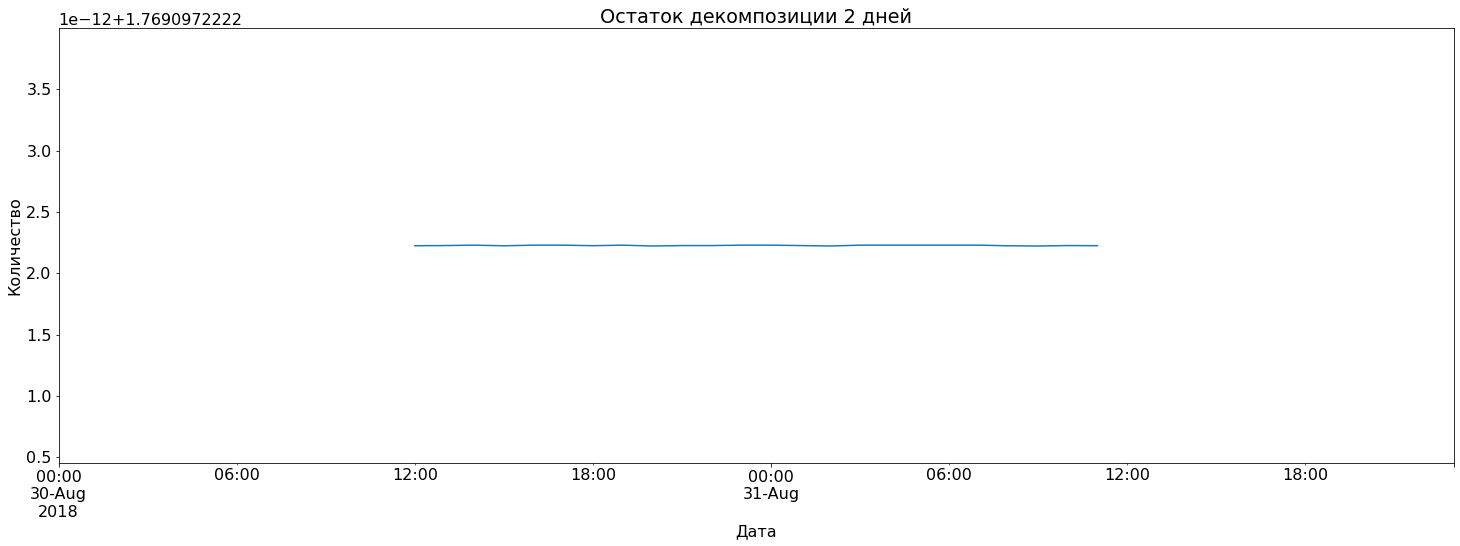

In [33]:
# остаток декомпозиции 2 дней
resid_graph(decomposed_lt_2d, '2 дней')

Инсайты, полученные при анализе данных:
- наблюдается общая тенденция к увеличению заказов
- воскресенье чаще всего самый загруженный день, в то время как понедельник после воскресенья "проседает"
- меньше всего заказов в ранние утренние часы, пик приходится на ночное время 22-4

Временной ряд подвержен тренду, который меняется ежедневно от недели к неделе, а это значит что он не ячвляется стационарным.

Природа сезонности обусловлена скорее всего тем, что есть популярные и непопулярные рейсы. Люди охотнее берут билеты на привычное удобное время например вылет утром/прилет вечером. Тоже самое касается сезонности в днях недели, чаще люди летают в выходные.

In [34]:
data

,num_orders,rolling
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN
...,...,...
2018-08-31 19:00:00,136,173.3
2018-08-31 20:00:00,154,166.6
2018-08-31 21:00:00,159,162.9


## Обучение

In [35]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['weekday'] = data.index.dayofweek
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()
    
    return data

In [36]:
def train_test(data, lag_max, rolling_size):
    data_train = make_features(data, lag_max, rolling_size)
    train, val = train_test_split(data_train, shuffle=False, train_size=0.50)
    train = train.dropna()

    val, test = train_test_split(val, shuffle=False, test_size=.20)

    features_train = train.drop('num_orders', axis=1)
    target_train = train.num_orders

    features_valid = val.drop('num_orders', axis=1)
    target_valid = val.num_orders


    return features_train, target_train, features_valid, target_valid, test

In [37]:
random_state = 88888
max_rmse = 48

In [38]:
#  LinearRegression
start_time = time.time()
for lag_max in range(1, 100):
    for rolling_size in range(1, 100):
        features_train, target_train,features_valid, target_valid, test_1 = train_test(data, lag_max, rolling_size)

        model = LinearRegression()
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        
        rmse = mean_squared_error(target_valid,predictions, squared = False)
        
  

        if rmse < max_rmse:
            best_rmse_1 = rmse
            best_max_lag = lag_max
            best_rolling_mean_size = rolling_size
            best_model_1 = model
            features_train_1, target_train_1,features_valid_1, target_valid_1, test_1 = features_train, target_train ,features_valid, target_valid, test_1
            
finish_time = time.time()                
time_1 = finish_time - start_time

print('Модель LinearRegression')              
print('RMSE =', best_rmse_1)
print('lag', best_max_lag)
print('окно', best_rolling_mean_size)
print('Затраченное время', time_1)

Модель LinearRegression
RMSE = 26.660272792642335
lag 99
окно 99
Затраченное время 1023.6676189899445


In [39]:
#  DecisionTreeRegressor

start_time = time.time()
for lag_max in range(1, 20):                 
    for rolling_size in range(1, 35):
        for max_depth in range(2, 6):
            features_train, target_train,features_valid, target_valid, test_2 = train_test(data, lag_max, rolling_size)

            model = DecisionTreeRegressor(max_depth=max_depth, random_state = random_state)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
        
            rmse = mean_squared_error(target_valid,predictions, squared = False)
    
            if rmse < max_rmse:
                best_rmse_2 = rmse
                best_max_lag = lag_max
                best_rolling_mean_size = rolling_size
                best_max_depth = max_depth
                best_model_2 = model
                
finish_time = time.time()    
time_2 = finish_time - start_time
print('Модель DecisionTreeRegressor')            
print('RMSE =', best_rmse_2)
print('lag', best_max_lag)
print('окно', best_rolling_mean_size)
print('глубина', best_max_depth)
print('Затраченное время', time_2)

Модель DecisionTreeRegressor
RMSE = 33.884351990665294
lag 19
окно 34
глубина 5
Затраченное время 384.8292815685272


In [40]:
#  LGBMRegressor

start_time = time.time()
for lag_max in range(1, 20):                 
    for rolling_size in range(1, 10):
        for max_depth in range(2, 6):
            for learning_rate in [0.1, 0.3, 0.5]:
                features_train, target_train,features_valid, target_valid, test_2 = train_test(data, lag_max, rolling_size)
            
                model = LGBMRegressor(max_depth=max_depth, learning_rate = learning_rate
                                  , random_state = random_state, num_leaves = 25
                                 , verbose = -1, force_col_wise = True)
                model.fit(features_train, target_train)
                predictions = model.predict(features_valid)
            
                rmse = mean_squared_error(target_valid,predictions, squared = False)
    
                if rmse < max_rmse:
                    best_rmse_3 = rmse
                    best_max_lag = lag_max
                    
                    best_rolling_mean_size = rolling_size
                    best_max_depth = max_depth
                    best_learning_rate = learning_rate
                    best_model_3 = model

                
finish_time = time.time()    
time_3 = finish_time - start_time
print('Модель LGBMRegressor')            
print('RMSE =', best_rmse_3)
print('lag', best_max_lag)
print('окно', best_rolling_mean_size)
print('глубина', best_max_depth)
print('Затраченное время', time_3)

Модель LGBMRegressor
RMSE = 30.69803800649096
lag 19
окно 9
глубина 5
Затраченное время 462.45383191108704


In [41]:
columns=['RMSE','Время']

pivot = pd.DataFrame(columns = columns
                               , index = ['LinearRegression'
                                          ,'DecisionTreeRegressor'
                                          , 'LGBMRegressor'])
pivot['RMSE'] = round(best_rmse_1,3), round(best_rmse_2,3), round(best_rmse_3,3)
pivot['Время'] = time_1, time_2, time_3
pivot

,RMSE,Время
LinearRegression,26.660,1023.667619
DecisionTreeRegressor,33.884,384.829282
LGBMRegressor,30.698,462.453832


Лучшие показатели на валидационной выборке дает модель LGBMRegressor. 

## Тестирование

In [42]:
features_test = test_1.drop('num_orders', axis=1)
target_test = test_1.num_orders

In [43]:
# Константная модель
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train_1, target_train_1)
dummy_predict = pd.DataFrame(dummy_model.predict(features_test))
dummy_rmse = mean_squared_error(target_test,dummy_predict, squared = False)
dummy_rmse

94.8168293910665

In [44]:
predictions = best_model_1.predict(features_test)
rsme = mean_squared_error(target_test, predictions, squared = False)
print('RMSE LinearRegression', rsme)

RMSE LinearRegression 46.112752649336876


In [45]:
if dummy_rmse >= rmse:
    print('Модель подобрана верно')
else:
    print('Все плохо')

Модель подобрана верно


Лидирующая модель по валидационной выборке LGBMRegressor доказала свое превосходство.